In [30]:
import os
import cv2
from deepface import DeepFace
#from deepface.modules import functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from time import time
from keras.preprocessing.image import ImageDataGenerator

# Local descriptors
from skimage.feature import hog, local_binary_pattern
from skimage import  exposure
from skimage import feature

# Classifiers
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [21]:
def GetPredictions(X_train, X_test, y_train, y_test, model, parameters):
    model_name = type(model).__name__
    print(f"{model_name} training...")
    t0 = time()
    
    # Grid search across parameter range
    clf = GridSearchCV(model, parameters, cv=5)
    clf = clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(X_test)
   
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test

In [22]:
def calc_embs(model, X, batch_size=2):
    norm_images = X
    pd = []
    for start in range(0, len(norm_images), batch_size):
        pd.append(model.forward(norm_images[start:start+batch_size]))
    return l2_normalize(np.concatenate(pd))

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [23]:
def save_image_with_error_handling(dest_folder, class_name, n_images, image):
    try:
        cv2.imwrite(os.path.join(dest_folder, os.path.join(class_name, str(n_images) + '_faces.jpg')), image)
    except cv2.error as e:
        print(f"An error occurred while saving image {str(n_images)}: {e}")

In [24]:
# Data location
folder = "data/rvf10k/train"
dest_folder = "data/roi_dataset"
cascade_path = "data/haarcascade_frontalface_default.xml"

# Counter for the number of classes in the dataset
nclasses = 0
# Counter for samples per class
nperclass = []
# Label for each class (name of the subfolder)
classlabels = []

n_images = 0

# Assumes that there is a subfolder per class in the given path
for class_name in os.listdir(folder):
    # Each subfolder implies one more class
    nclasses += 1
    # Initially, this class has no samples
    nsamples = 0

    # Compose the path
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Assumes images are in jpg format
        if file_name.endswith('.jpg'):
            # Read the image
            image = cv2.imread(os.path.join(class_folder, file_name))

            # Extract face as ROI
            faceCascade = cv2.CascadeClassifier(cascade_path)
            faces = faceCascade.detectMultiScale(
                image,
                scaleFactor=1.3,
                minNeighbors=5,
                minSize=(30, 30)
            )

            if len(faces) > 0:
                for x, y, w, h in faces:
                    image = image[y:y + h, x:x + w]
                    save_image_with_error_handling(dest_folder, class_name, n_images, image)
                    n_images += 1
            else:
                cv2.imwrite(
                    os.path.join(dest_folder, os.path.join(class_name, str(n_images) + '_faces.jpg')), image)
                n_images += 1

An error occurred while saving image 2979: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'

An error occurred while saving image 4222: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'

An error occurred while saving image 5718: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'

An error occurred while saving image 6045: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'



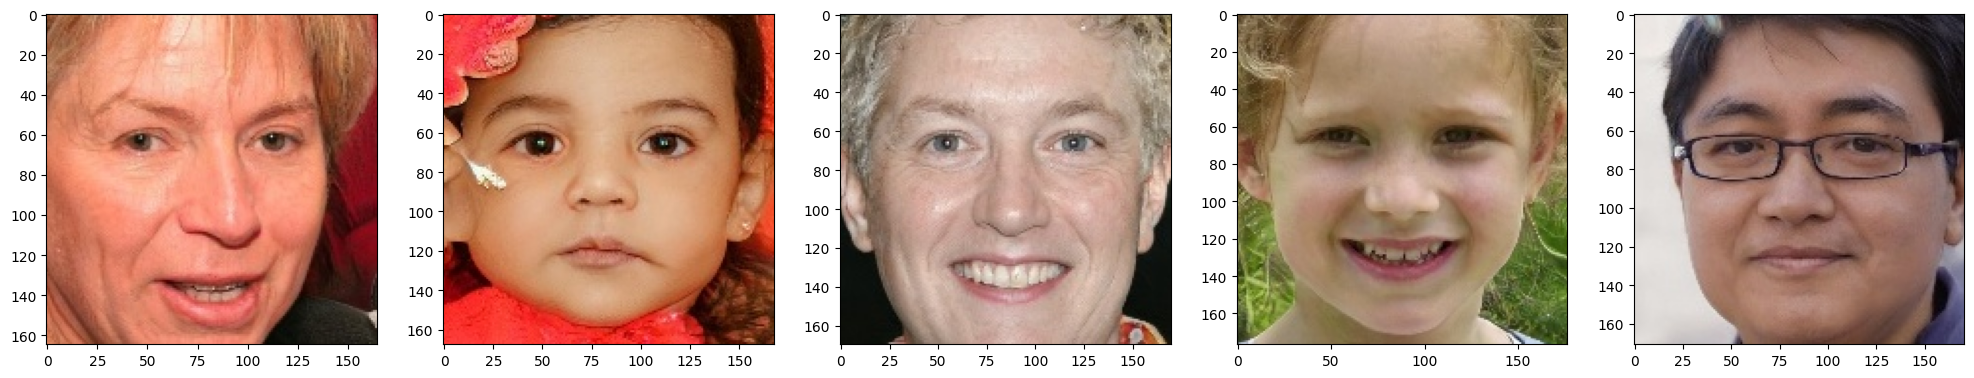

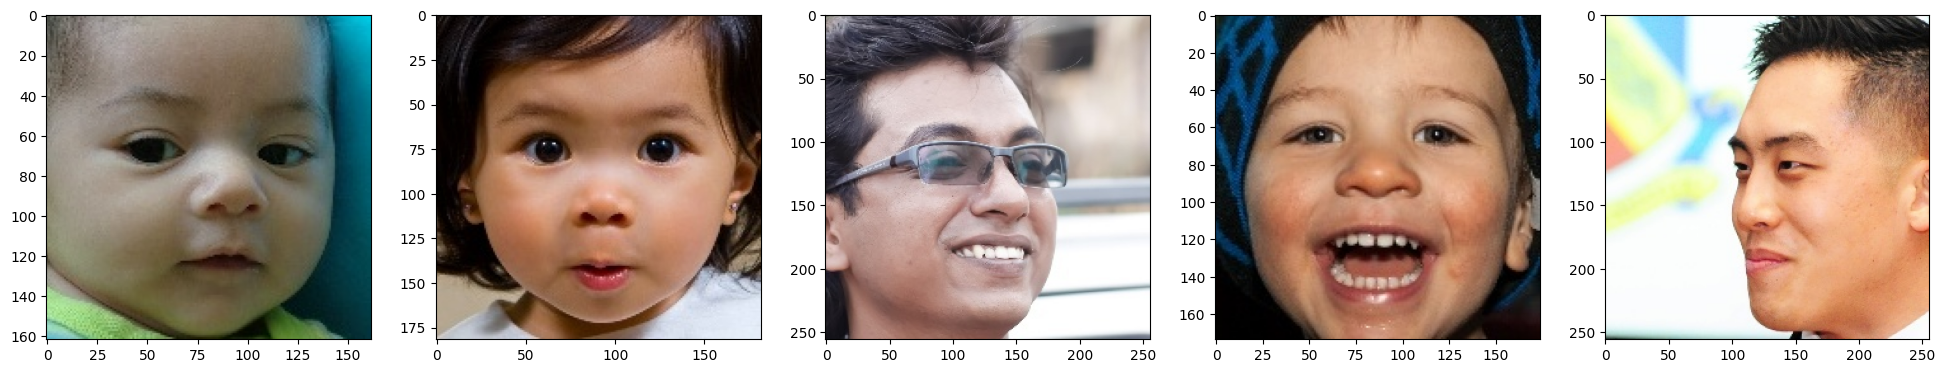

Features
(7003,)
(7003,)


In [26]:
# Deepface
# Available models ['VGG-Face', 'Facenet', 'OpenFace', 'DeepFace', 'DeepID', 'Dlib']
model_deepface = DeepFace.build_model("VGG-Face")

target_size = (model_deepface.input_shape[0], model_deepface.input_shape[1])
dim = (int(target_size[0]), int(target_size[1]))

# Data location
folder = "data/roi_dataset"

# Counter for the number of classes in the dataset
nclasses = 0
# Counter for samples per class
nperclass = []
# Label for each class (name of the subfolder)
classlabels = []
# Initialize data structures and their corresponding labels
X = []
Y = []
XVGGFace = []

# Default resolution value for matplotlib
dpi = matplotlib.rcParams['figure.dpi']
# Number of sample images from each class to show
nims2show = 5

# Assumes that there is a subfolder per class in the given path
for class_name in os.listdir(folder):
    # Each subfolder implies one more class
    nclasses += 1
    # Initially, this class has no samples
    nsamples = 0

    # Compose the path
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Assumes images are in jpg format
        if file_name.endswith('.jpg'):
            # Read the image
            image = cv2.imread(os.path.join(class_folder, file_name))
            
            # Extract sizes
            height, width, depth = image.shape
            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            X.append(image_rgb.reshape(-1))
            
            # Deepface with VGG Face
            # Get embeddings
            img_embedding = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
            img_embedding = calc_embs(model_deepface, np.expand_dims(img_embedding, axis=0))
            XVGGFace.append(img_embedding[0])
                    
            # Add numerical label of the sample
            Y.append(nclasses - 1)
            
            # Show the first nims2show samples of each class
            if nsamples < nims2show:
                if nsamples == 0:
                    figsize = 15 * width / float(dpi), 15 * height / float(dpi)
                    fig = plt.figure(figsize=figsize)
                
                fig.add_subplot(1, nims2show, nsamples + 1)
                plt.imshow(image_rgb, vmin=0, vmax=255)

            
            # Increase the number of samples
            nsamples += 1
    plt.show()
    nperclass.append(nsamples)
    classlabels.append(class_name)
    
# Convert X and Y to numpy arrays
Y = np.array(Y, dtype='float64')
XVGGFace = np.array(XVGGFace, dtype='float32')

# Show information about the read dataset
# Debugging
print("Features")
print(XVGGFace.shape)
print(Y.shape)
# Get number of samples and features
# Get names of the classes
class_names = np.array(classlabels)
n_classes = class_names.shape[0]

In [27]:
# StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("Fold %d" % fold)
    print("# samples in training set %d" % train_index.shape[0])
    print("# samples in test set %d" % test_index.shape[0])
    fold += 1

Fold 1
# samples in training set 5602
# samples in test set 1401
Fold 2
# samples in training set 5602
# samples in test set 1401
Fold 3
# samples in training set 5602
# samples in test set 1401
Fold 4
# samples in training set 5603
# samples in test set 1400
Fold 5
# samples in training set 5603
# samples in test set 1400


+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1

Deepface/VGG-Face
SVC training...
done in 39.772s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01)
Predicting
done in 0.760s

Deepface/VGG-Face + SVM Metrics
              precision    recall  f1-score   support

        fake       0.50      0.99      0.67       701
        real       0.67      0.02      0.04       700

    accuracy                           0.51      1401
   macro avg       0.58      0.51      0.35      1401
weighted avg       0.58      0.51      0.35      1401

Confusion matrix for VGG-Face + SVM:
[[694   7]
 [686  14]]


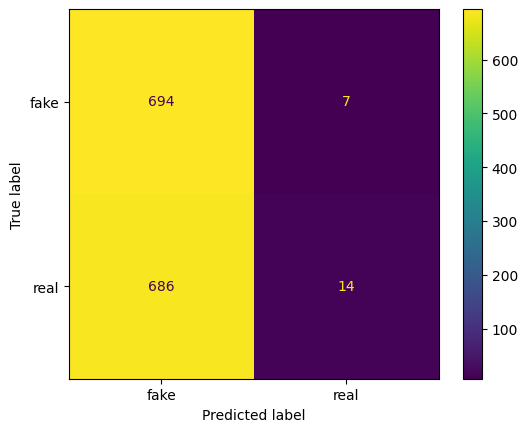

RandomForestClassifier training...
done in 4.811s
Best estimator found by grid search:
RandomForestClassifier()
Predicting
done in 0.010s

Deepface/VGG-Face + RF Metrics
              precision    recall  f1-score   support

        fake       0.51      0.98      0.67       701
        real       0.69      0.05      0.09       700

    accuracy                           0.51      1401
   macro avg       0.60      0.51      0.38      1401
weighted avg       0.60      0.51      0.38      1401

Confusion matrix for VGG-Face + RF:
[[686  15]
 [667  33]]


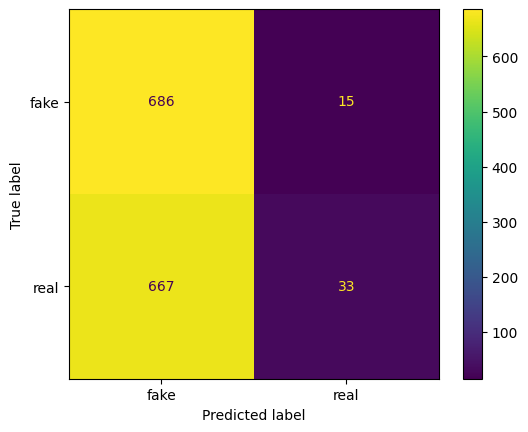

*********************
Fold 1

Deepface/VGG-Face
SVC training...
done in 43.408s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.01)
Predicting
done in 0.742s

Deepface/VGG-Face + SVM Metrics
              precision    recall  f1-score   support

        fake       0.50      0.99      0.67       701
        real       0.65      0.02      0.03       700

    accuracy                           0.50      1401
   macro avg       0.57      0.50      0.35      1401
weighted avg       0.57      0.50      0.35      1401

Confusion matrix for VGG-Face + SVM:
[[695   6]
 [689  11]]


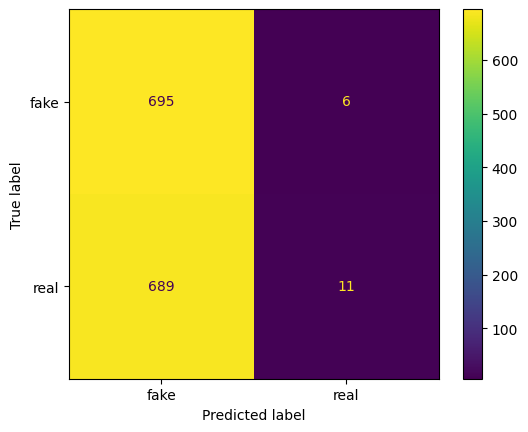

RandomForestClassifier training...
done in 5.933s
Best estimator found by grid search:
RandomForestClassifier()
Predicting
done in 0.014s

Deepface/VGG-Face + RF Metrics
              precision    recall  f1-score   support

        fake       0.50      0.97      0.66       701
        real       0.46      0.02      0.05       700

    accuracy                           0.50      1401
   macro avg       0.48      0.50      0.35      1401
weighted avg       0.48      0.50      0.35      1401

Confusion matrix for VGG-Face + RF:
[[681  20]
 [683  17]]


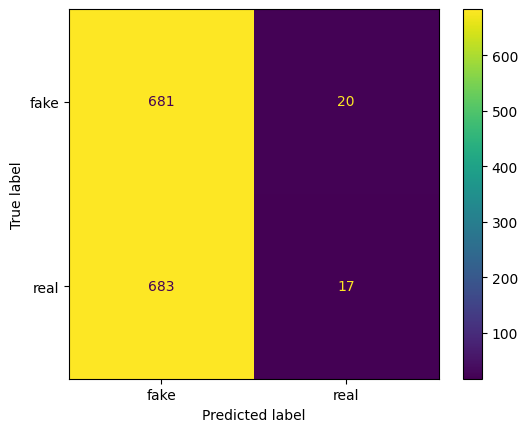

*********************
Fold 1

Deepface/VGG-Face
SVC training...
done in 78.048s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.005)
Predicting
done in 1.224s

Deepface/VGG-Face + SVM Metrics
              precision    recall  f1-score   support

        fake       0.50      0.99      0.66       700
        real       0.53      0.01      0.03       701

    accuracy                           0.50      1401
   macro avg       0.51      0.50      0.35      1401
weighted avg       0.51      0.50      0.35      1401

Confusion matrix for VGG-Face + SVM:
[[691   9]
 [691  10]]


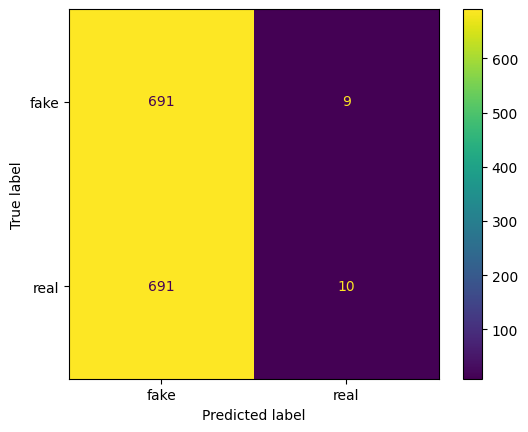

RandomForestClassifier training...
done in 8.054s
Best estimator found by grid search:
RandomForestClassifier()
Predicting
done in 0.024s

Deepface/VGG-Face + RF Metrics
              precision    recall  f1-score   support

        fake       0.50      0.97      0.66       700
        real       0.49      0.02      0.05       701

    accuracy                           0.50      1401
   macro avg       0.49      0.50      0.35      1401
weighted avg       0.49      0.50      0.35      1401

Confusion matrix for VGG-Face + RF:
[[682  18]
 [684  17]]


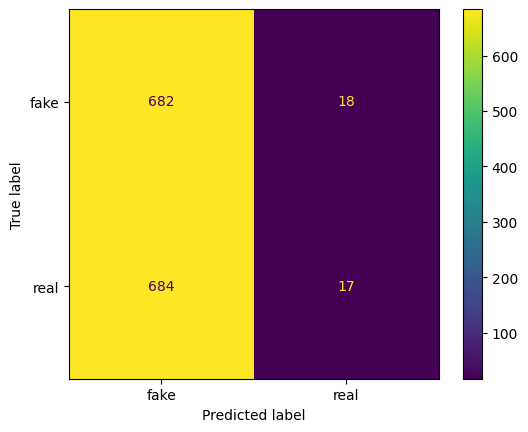

*********************
Fold 1

Deepface/VGG-Face
SVC training...
done in 88.028s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.01)
Predicting
done in 1.557s

Deepface/VGG-Face + SVM Metrics
              precision    recall  f1-score   support

        fake       0.50      0.99      0.67       700
        real       0.71      0.01      0.03       700

    accuracy                           0.50      1400
   macro avg       0.61      0.50      0.35      1400
weighted avg       0.61      0.50      0.35      1400

Confusion matrix for VGG-Face + SVM:
[[696   4]
 [690  10]]


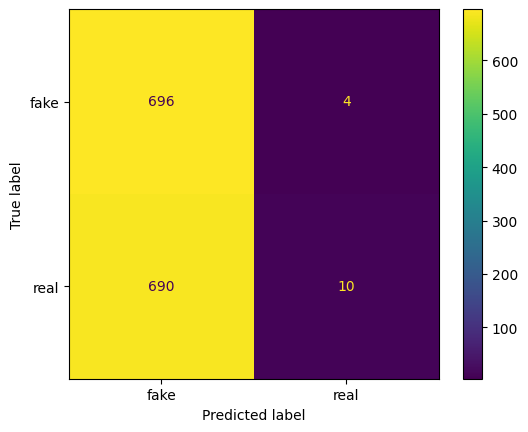

RandomForestClassifier training...
done in 8.689s
Best estimator found by grid search:
RandomForestClassifier()
Predicting
done in 0.021s

Deepface/VGG-Face + RF Metrics
              precision    recall  f1-score   support

        fake       0.50      0.98      0.66       700
        real       0.56      0.03      0.06       700

    accuracy                           0.50      1400
   macro avg       0.53      0.50      0.36      1400
weighted avg       0.53      0.50      0.36      1400

Confusion matrix for VGG-Face + RF:
[[683  17]
 [678  22]]


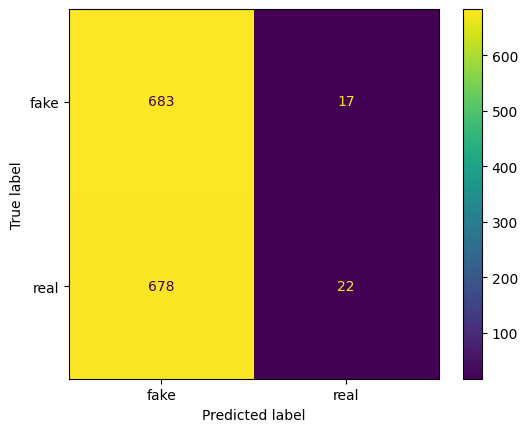

*********************
Fold 1

Deepface/VGG-Face
SVC training...
done in 77.015s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.01)
Predicting
done in 1.500s

Deepface/VGG-Face + SVM Metrics
              precision    recall  f1-score   support

        fake       0.50      0.99      0.67       700
        real       0.59      0.02      0.04       700

    accuracy                           0.50      1400
   macro avg       0.55      0.50      0.35      1400
weighted avg       0.55      0.50      0.35      1400

Confusion matrix for VGG-Face + SVM:
[[691   9]
 [687  13]]


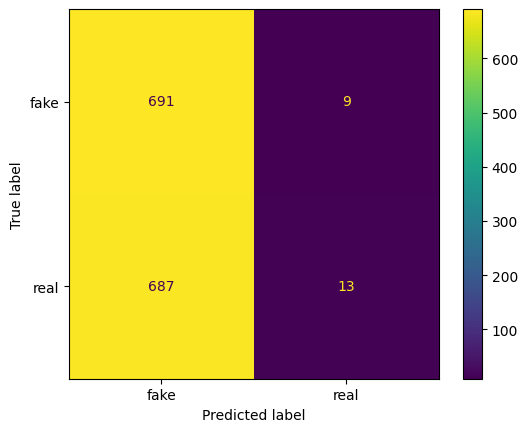

RandomForestClassifier training...
done in 7.216s
Best estimator found by grid search:
RandomForestClassifier()
Predicting
done in 0.019s

Deepface/VGG-Face + RF Metrics
              precision    recall  f1-score   support

        fake       0.50      0.97      0.66       700
        real       0.61      0.05      0.09       700

    accuracy                           0.51      1400
   macro avg       0.56      0.51      0.38      1400
weighted avg       0.56      0.51      0.38      1400

Confusion matrix for VGG-Face + RF:
[[679  21]
 [667  33]]


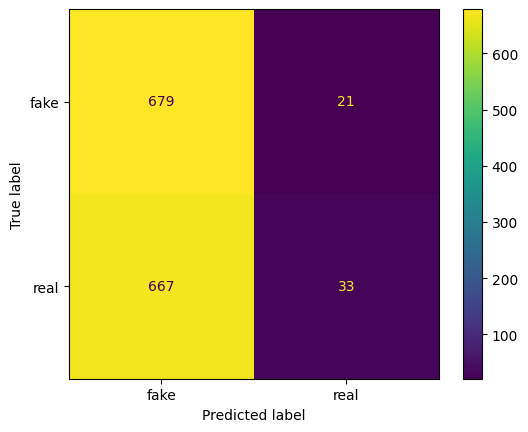

In [31]:
print("+++++++++++++++++++++++++++++++++++++++++++\n")

# KNN 
precs_vgg_svm, recs_vgg_svm, acc_vgg_svm = [], [], []

precs_vgg_rf, recs_vgg_rf, acc_vgg_rf = [], [], []


SVM = SVC(kernel='rbf', class_weight='balanced')
SVM_parameters = {
    'C': [1e3, 5e3],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01],
}

RF = RandomForestClassifier()
RF_parameters = {
    'n_estimators': [100, 150, 200],
}

fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("*********************\nFold %d" % fold)
        
    #VGG-Face - SVM
    print("\nDeepface/VGG-Face")
    XVGGFace=XVGGFace.reshape(-1, 1)
    y_pred, y_test = GetPredictions(XVGGFace[train_index], XVGGFace[test_index],Y[train_index], Y[test_index], SVM, SVM_parameters)
    print("\nDeepface/VGG-Face + SVM Metrics")
    precs_vgg_svm.append(precision_score(y_test, y_pred))
    recs_vgg_svm.append(recall_score(y_test, y_pred))
    acc_vgg_svm.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    print("Confusion matrix for VGG-Face + SVM:")
    cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()
        
    #VGG-Face - Random Forest
    y_pred, y_test = GetPredictions(XVGGFace[train_index], XVGGFace[test_index],Y[train_index], Y[test_index], RF, RF_parameters)
    print("\nDeepface/VGG-Face + RF Metrics")
    precs_vgg_rf.append(precision_score(y_test, y_pred))
    recs_vgg_rf.append(recall_score(y_test, y_pred))
    acc_vgg_rf.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))

    print("Confusion matrix for VGG-Face + RF:")
    cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()
